# BatchNorm before and after Activation for Network-in-Network CIFAR-10 Classifier

### Network Architecture

**References**

The CNN architecture is based on 

- Lin, Min, Qiang Chen, and Shuicheng Yan. "[Network in network](https://arxiv.org/abs/1312.4400)." arXiv preprint arXiv:1312.4400 (2013).

This paper compares using BatchNorm before the activation function as suggested in

- Ioffe, Sergey, and Christian Szegedy. "[Batch normalization: Accelerating deep network training by reducing internal covariate shift.](https://arxiv.org/abs/1502.03167)" arXiv preprint arXiv:1502.03167 (2015)

and after the activation function as it is nowadays common practice.

![nin-arch](images/nin/nin-arch2.png)

In [1]:
import sys
sys.path.append("/Users/ZRC")
sys.path

['',
 '/anaconda/envs/py36/lib/python36.zip',
 '/anaconda/envs/py36/lib/python3.6',
 '/anaconda/envs/py36/lib/python3.6/lib-dynload',
 '/anaconda/envs/py36/lib/python3.6/site-packages',
 '/anaconda/envs/py36/lib/python3.6/site-packages/IPython/extensions',
 '/data/home/zhangruochi/.ipython',
 '/Users/ZRC']

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
from torch.utils.data import Subset


from torchvision import datasets
from torchvision import transforms

from torchsummary import summary

In [4]:
from coke.visualization.image import show_batch

ModuleNotFoundError: No module named 'coke'

## Model Settings

In [5]:
# Hyperparameters

BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
RANDOM_SEED = 7

# Architecture
NUM_CLASSES = 10
GRAYSCALE = True

# # other
# torch.cuda.empty_cache()
DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [6]:
data_transforms = {"train": transforms.Compose([
                            transforms.Resize((32,32)),
                            transforms.ToTensor()]),
                    "test": transforms.Compose([
                            transforms.Resize((32,32)),
                            transforms.ToTensor()])
                   }

In [7]:
train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)



train_and_valida_dataset = datasets.MNIST(root = "data",
                                train = True,
                                transform = data_transforms["train"],
                                download=True)

test_dataset = datasets.MNIST(root = "data",
                                train = False,
                                transform = data_transforms["test"],
                                download=False)

train_dataset = Subset(train_and_valida_dataset, train_indices)
valid_dataset = Subset(train_and_valida_dataset, valid_indices)




train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=4)

valid_dataloader = DataLoader(dataset = valid_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=4)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=4)

data_loader = {"train": train_dataloader, 
               "val": valid_dataloader,
               "test": test_dataloader}

In [8]:
batch_samples,labels = next(iter(train_dataloader))
print(batch_samples.size(),labels.size())
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

torch.Size([64, 1, 32, 32]) torch.Size([64])


NameError: name 'show_batch' is not defined

In [ ]:
batch_samples,labels = next(iter(valid_dataloader))
print(batch_samples.shape,labels.shape)
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

In [ ]:
batch_samples,labels = next(iter(test_dataloader))
print(batch_samples.shape,labels.shape)
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

## Model

![](images/nin/nin-arch.png)

In [15]:
class NiNZrc(torch.nn.Module):
    def __init__(self, num_classes, grayscale = False):
        super(NiNZrc, self).__init__()
        
        if grayscale:
            in_channels = 1
        else:
            in_channels = 3
            
        self.classifier = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 192, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(192, 160, kernel_size=1, stride=1, padding=0),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(160,  96, kernel_size=1, stride=1, padding=0),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            torch.nn.Dropout(0.5),

            torch.nn.Conv2d(96, 192, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
            torch.nn.ReLU(inplace=True),
            torch.nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
            torch.nn.Dropout(0.5),

            torch.nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(192,  num_classes, kernel_size=1, stride=1, padding=0),
            torch.nn.ReLU(inplace=True),
            torch.nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        for layer in self.modules():
            if isinstance(layer, torch.nn.Conv2d):
                n = layer.kernel_size[0] * layer.kernel_size[1] * layer.out_channels
                layer.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(layer, torch.nn.BatchNorm2d):
                layer.weight.data.fill_(1)
                layer.bias.data.zero_()
            
        
        self.global_avg_pooling = torch.nn.AdaptiveAvgPool2d(1)
        
    def forward(self, x):
        x = self.classifier(x)
        logits = torch.squeeze(self.global_avg_pooling(x))
        probas = torch.softmax(logits, dim=1)
        return logits, probas

In [16]:
def test_nin():
    model = NiNZrc(10).to(DEVICE)
    summary(model, (3,32,32))
    
test_nin()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 192, 32, 32]          14,592
              ReLU-2          [-1, 192, 32, 32]               0
            Conv2d-3          [-1, 160, 32, 32]          30,880
              ReLU-4          [-1, 160, 32, 32]               0
            Conv2d-5           [-1, 96, 32, 32]          15,456
              ReLU-6           [-1, 96, 32, 32]               0
         MaxPool2d-7           [-1, 96, 16, 16]               0
           Dropout-8           [-1, 96, 16, 16]               0
            Conv2d-9          [-1, 192, 16, 16]         460,992
             ReLU-10          [-1, 192, 16, 16]               0
           Conv2d-11          [-1, 192, 16, 16]          37,056
             ReLU-12          [-1, 192, 16, 16]               0
           Conv2d-13          [-1, 192, 16, 16]          37,056
             ReLU-14          [-1, 192,

In [17]:
model = NiNZrc(num_classes=NUM_CLASSES, grayscale=GRAYSCALE)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [18]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [19]:
def train_model(model, data_loader, optimizer, num_epochs,batch_size, device,metric_func, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    
    loss_list = []
    train_acc_list, valid_acc_list = [], []
    
    for epoch in range(num_epochs):
        # set training mode
        model.train() 
        for batch_idx, (features, targets) in enumerate(data_loader["train"]):
            features = features.to(device)
            targets = targets.to(device)


            ## forward pass
            logits, probas = model(features)
            loss = F.cross_entropy(logits,targets)

            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            loss_list.append(loss.item())
            if not batch_idx % 50:
                print ('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.2f}'.format(
                    epoch+1, num_epochs, batch_idx, 
                         len(train_dataset)//batch_size, loss))

        with torch.set_grad_enabled(False):
            train_acc = metric_func(model, data_loader["train"], device)
            valid_acc = metric_func(model, data_loader["val"], device)
            
            print('Epoch: {0:03d}/{1:03d} training accuracy: {2:.2f}'.format(
                  epoch+1, num_epochs, train_acc))
            
            print('Epoch: {0:03d}/{1:03d} validation accuracy: {2:.2f}'.format(
                  epoch+1, num_epochs, valid_acc))
            
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
            
    return loss_list, train_acc_list, valid_acc_list

In [20]:
loss_list, train_acc_list, valid_acc_list = train_model(model, 
            data_loader, 
            optimizer, 
            NUM_EPOCHS, 
            device = DEVICE, 
            batch_size = BATCH_SIZE,
            metric_func = compute_accuracy)

Epoch: 001/010 | Batch 000/921 | Loss: 2.30
Epoch: 001/010 | Batch 050/921 | Loss: 2.30
Epoch: 001/010 | Batch 100/921 | Loss: 2.30
Epoch: 001/010 | Batch 150/921 | Loss: 2.30
Epoch: 001/010 | Batch 200/921 | Loss: 2.24
Epoch: 001/010 | Batch 250/921 | Loss: 2.14
Epoch: 001/010 | Batch 300/921 | Loss: 1.92
Epoch: 001/010 | Batch 350/921 | Loss: 1.29
Epoch: 001/010 | Batch 400/921 | Loss: 1.50
Epoch: 001/010 | Batch 450/921 | Loss: 1.19
Epoch: 001/010 | Batch 500/921 | Loss: 1.25
Epoch: 001/010 | Batch 550/921 | Loss: 1.17
Epoch: 001/010 | Batch 600/921 | Loss: 0.90
Epoch: 001/010 | Batch 650/921 | Loss: 0.82
Epoch: 001/010 | Batch 700/921 | Loss: 0.90
Epoch: 001/010 | Batch 750/921 | Loss: 1.16
Epoch: 001/010 | Batch 800/921 | Loss: 0.56
Epoch: 001/010 | Batch 850/921 | Loss: 0.72
Epoch: 001/010 | Batch 900/921 | Loss: 0.69
Epoch: 001/010 training accuracy: 76.46
Epoch: 001/010 validation accuracy: 78.70
Epoch: 002/010 | Batch 000/921 | Loss: 0.74
Epoch: 002/010 | Batch 050/921 | Loss:

Epoch: 010/010 | Batch 000/921 | Loss: 0.44
Epoch: 010/010 | Batch 050/921 | Loss: 0.35
Epoch: 010/010 | Batch 100/921 | Loss: 0.41
Epoch: 010/010 | Batch 150/921 | Loss: 0.28
Epoch: 010/010 | Batch 200/921 | Loss: 0.23
Epoch: 010/010 | Batch 250/921 | Loss: 0.30
Epoch: 010/010 | Batch 300/921 | Loss: 0.37
Epoch: 010/010 | Batch 350/921 | Loss: 0.38
Epoch: 010/010 | Batch 400/921 | Loss: 0.37
Epoch: 010/010 | Batch 450/921 | Loss: 0.31
Epoch: 010/010 | Batch 500/921 | Loss: 0.42
Epoch: 010/010 | Batch 550/921 | Loss: 0.16
Epoch: 010/010 | Batch 600/921 | Loss: 0.33
Epoch: 010/010 | Batch 650/921 | Loss: 0.36
Epoch: 010/010 | Batch 700/921 | Loss: 0.10
Epoch: 010/010 | Batch 750/921 | Loss: 0.26
Epoch: 010/010 | Batch 800/921 | Loss: 0.37
Epoch: 010/010 | Batch 850/921 | Loss: 0.22
Epoch: 010/010 | Batch 900/921 | Loss: 0.30
Epoch: 010/010 training accuracy: 88.07
Epoch: 010/010 validation accuracy: 89.20


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

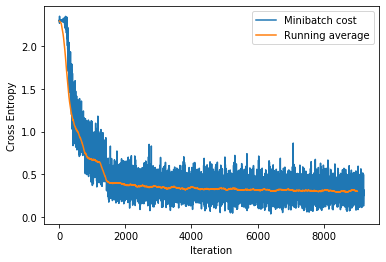

In [22]:
plt.plot(loss_list, label='Minibatch cost')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

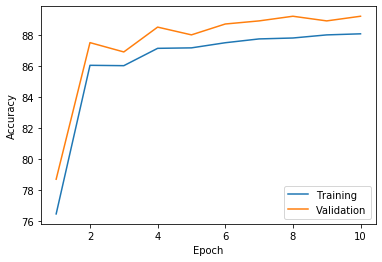

In [23]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
with torch.set_grad_enabled(False):
    test_acc = compute_accuracy(model=model,
                           data_loader=data_loader["test"],
                           device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                            data_loader=data_loader["val"],
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 89.20%
Test ACC: 87.94%


## Reference

- https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a
- https://github.com/rasbt/deeplearning-models